# Procesamiento de dataset "asteroides" usando KNN

In [16]:
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
# Importamos la librería que necesitamos
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn import metrics
import sys
sys.path.append('../Code')
from CustomTransformers import CollinearityDropper, ColumnDropper
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


In [17]:
clfs = []
df = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/asteroids_nasa.csv')


## Uso KNN directamente

Quito solo las columnas no numericas o que me generar algun problema

In [18]:
X = df.drop("Hazardous",axis=1)
y = df["Hazardous"]
#Elimino columnas de fechas, no es necesario separar fit de transform porque no tiene que aprender nada
cd = ColumnDropper(columns=['Close Approach Date','Orbit Determination Date', 'Equinox', 'Orbiting Body'])
X = cd.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)

param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
creport = classification_report(y_test,y_pred)
print(creport)
clfs.append((str(gs.best_estimator_), y_test, gs.predict_proba(X_test)[:, 1]))   

              precision    recall  f1-score   support

       False       0.84      1.00      0.91      1180
        True       0.00      0.00      0.00       227

    accuracy                           0.84      1407
   macro avg       0.42      0.50      0.46      1407
weighted avg       0.70      0.84      0.77      1407



c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

El resultado es naturalmente malo, ni siquiera escalé. Recordemos que con arboles tuvimos un gran rendimiento.

## Escalemos las variables

Observar que para evitar la fuga de datos debo hacer el fit unicamente con la muestra de entrenamiento y el transform tanto en entrenamiento como en test. Es burocratico e incomodo y propenso a errores. Este mismo problema aplica a escaladores, imputadores, analisis de componentes principales, eliminado de outliers entre otra posibles transformaciones. 

In [19]:
X = df.drop("Hazardous",axis=1)
y = df["Hazardous"]
#Elimino columnas de fechas
cd = ColumnDropper(columns=['Close Approach Date','Orbit Determination Date', 'Equinox', 'Orbiting Body'])
X = cd.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)


ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
creport = classification_report(y_test,y_pred)
print(creport)

clfs.append((str(gs.best_estimator_), y_test, gs.predict_proba(X_test)[:, 1]))   


              precision    recall  f1-score   support

       False       0.91      0.96      0.94      1180
        True       0.73      0.51      0.60       227

    accuracy                           0.89      1407
   macro avg       0.82      0.74      0.77      1407
weighted avg       0.88      0.89      0.88      1407



## Quito variables redundantes

Vamos mejorando. ¿Que mas puedo hacer? KNN se reciente mucho por la cantidad de variables, no tiene la inteligencia de los árboles, debería, por ejemplo quitar variables redundantes.

Automatizo en un clase propia el eliminado de columnas tengan alta colinealidad (Dejo solo una)

In [20]:
X = df.drop("Hazardous",axis=1)
y = df["Hazardous"]
#Elimino columnas de fechas
cd = ColumnDropper(columns=['Close Approach Date','Orbit Determination Date', 'Equinox', 'Orbiting Body'])
X = cd.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)


cd = CollinearityDropper(columns=X.columns, min_coef=0.9)
cd.fit(X_train)
X_train = cd.transform(X_train)
X_test = cd.transform(X_test)

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
creport = classification_report(y_test,y_pred)
print(creport)
clfs.append((str(gs.best_estimator_), y_test, gs.predict_proba(X_test)[:, 1]))   

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      1180
        True       0.72      0.63      0.67       227

    accuracy                           0.90      1407
   macro avg       0.82      0.79      0.80      1407
weighted avg       0.90      0.90      0.90      1407



In [21]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
creport = classification_report(y_test,y_pred)
print(creport)
clfs.append((str(gs.best_estimator_), y_test, gs.predict_proba(X_test)[:, 1]))  

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      1180
        True       0.72      0.63      0.67       227

    accuracy                           0.90      1407
   macro avg       0.82      0.79      0.80      1407
weighted avg       0.90      0.90      0.90      1407



Seguimos mejorando, ¿Que mas puedo hacer? 

## Quito variables sin capacidad predictiva

Me quedo solo con las columnas que tengan impacto y valor predictor, se obtuvieron mediante busqueda exhaustiva. 

In [23]:
X = df.drop("Hazardous",axis=1)
y = df["Hazardous"]
#Elimino columnas de fechas
cd = ColumnDropper(columns=['Close Approach Date','Orbit Determination Date', 'Equinox', 'Orbiting Body'])
X = cd.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)

X_train  = X_train.loc[:,['Absolute Magnitude', 'Minimum Orbit Intersection']]
X_test   = X_test.loc[:,['Absolute Magnitude', 'Minimum Orbit Intersection']]
cd = CollinearityDropper(columns=X_train.columns, min_coef=0.9)
cd.fit(X_train)
X_train = cd.transform(X_train)
X_test = cd.transform(X_test)
ss = StandardScaler()
ss.fit(X_train)
X_train.loc[:,X_train.columns] = ss.transform(X_train)
X_test.loc[:,X_test.columns] = ss.transform(X_test)

gs = KNeighborsClassifier(weights='distance', n_neighbors=33, metric='manhattan')
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
creport = classification_report(y_test,y_pred)
print(creport)
clfs.append((str(gs), y_test, gs.predict_proba(X_test)[:, 1]))   



              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1180
        True       0.98      0.98      0.98       227

    accuracy                           0.99      1407
   macro avg       0.99      0.99      0.99      1407
weighted avg       0.99      0.99      0.99      1407



Al final le terminamos sacando lo mismo que árbol.

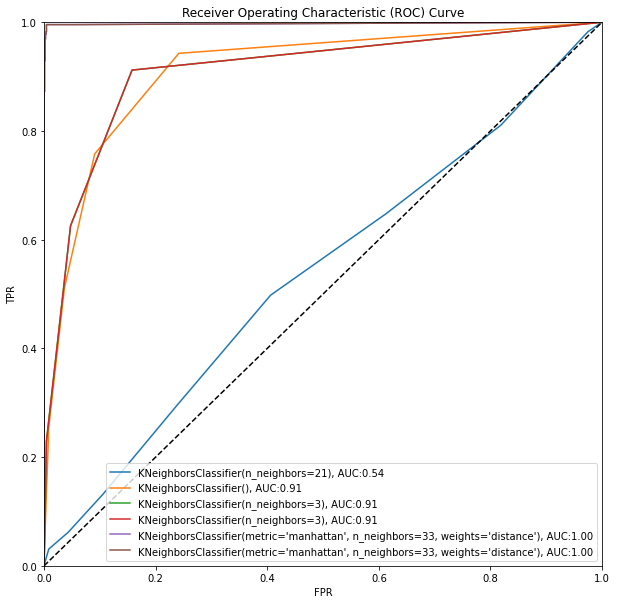

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
def roc_curves(clfs, prob=0.5):
    plt.figure(figsize=(10, 10))
    for clf_name, y_test, y_proba in clfs:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=clf_name+", AUC:{:.2f}".format(auc_val))


    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
roc_curves(clfs)

In [44]:
pl = Pipeline(steps=[('scaler', StandardScaler()), 
                     ('knn', GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5))])
pl.fit(X_train, y_train)
y_pred_knn = pl.predict(X_test)

---------------

# Backup

Busqueda exhaustiva de columnas

In [ ]:
#Buscamos columnas...
X = df.drop("Hazardous",axis=1)
y = df["Hazardous"]
#Elimino columnas de fechas
cd = ColumnDropper(columns=['Close Approach Date','Orbit Determination Date', 'Equinox', 'Orbiting Body'])
X = cd.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)


cd = CollinearityDropper(columns=X.columns, min_coef=0.9)
cd.fit(X_train)
X_train = cd.transform(X_train)
X_test = cd.transform(X_test)

ss = StandardScaler()
ss.fit(X_train)
X_train.loc[:,X_train.columns] = ss.transform(X_train)
X_test.loc[:,X_test.columns] = ss.transform(X_test)

param_grid = {'n_neighbors': np.arange(1, 51, 2), 
              'weights': ['distance', 'uniform'], 
              'metric': ['euclidean', 'manhattan']}

gs = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=False)
#sss = SimpleExhaustiveSearch(estimator=knn, scoring="accuracy", cv=5, sample_size=0.5, groups=[2,3,4], stratify=y_train, verbose=True)
gses = GridExhaustiveSearch(estimator=gs, sample_size=0.9, stratify=None, groups=[2,3,4], verbose=True)
gses.fit(X_train, y_train)
print("==>>best score {:.2f}, columns {}, params {}".format(gses.best_score_, gses.best_subset_, gses.best_params_)) 